# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [21]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize((224,224)),                          # smaller edge of image resized to 224
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test',
                         cocoapi_loc='/home/jupyter/')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

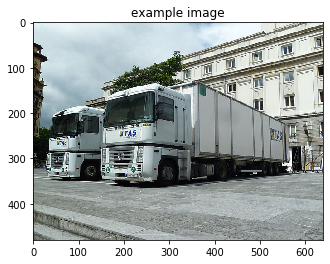

In [22]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [23]:
print(orig_image.shape)
print(image.shape)

torch.Size([1, 480, 640, 3])
torch.Size([1, 3, 224, 224])


In [24]:
# Visualize sample image, before pre-processing.
# plt.imshow(np.squeeze(image))
# plt.title('transformed image')
# plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [25]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [26]:
# Watch for any changes in model.py, and re-load it automatically.
%load_ext autoreload
%autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# TODO #2: Specify the saved models to load.
encoder_file = 'encoder-3.pkl'
decoder_file = 'decoder-3.pkl'

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 512
hidden_size = 256

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)

encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, debug=True)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)

decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(8856, 512)
  (lstm): LSTM(512, 256, batch_first=True)
  (dec): Linear(in_features=256, out_features=8856, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [9]:
# import torch.utils.data as data

# # (Optional) TODO #2: Amend the image transform below.
# transform_train = transforms.Compose([ 
#     transforms.Resize(256),                          # smaller edge of image resized to 256
#     transforms.RandomAffine(degrees=15, translate=(.1,.1), shear=(10,10)),
#     transforms.RandomCrop(224),                      # get 224x224 crop from random location
#     transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
#     transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, 
#                            hue=0.1),  # randomly change the brightness, contrast and saturation of an image
#     transforms.ToTensor(),                           # convert the PIL Image to a tensor
#     transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
#                          (0.229, 0.224, 0.225))])

# # Build data loader.
# data_loader = get_loader(transform=transform_train,
#                          mode='train',
#                          batch_size=1,
#                          vocab_from_file=True)

# indices = data_loader.dataset.get_train_indices()
# # Create and assign a batch sampler to retrieve a batch with the sampled indices.
# new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
# data_loader.batch_sampler.sampler = new_sampler

# # Obtain the batch.
# images, captions = next(iter(data_loader))

# images.shape

# captions.shape

# images = images.to(device)
# captions = captions.to(device)
# # Obtain the embedded image features.
# features = encoder(images) #.unsqueeze(1)
# output = decoder(features,captions)


# features.shape

In [10]:
# output.view(-1, vocab_size)

In [11]:
# torch.cat((captions,captions), dim=0 ).view(-1)

In [8]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)
print(image.shape)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)
print(features.shape)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

torch.Size([1, 3, 224, 224])
torch.Size([1, 1, 512])
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size(

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [9]:
idx2word = data_loader.dataset.vocab.idx2word

In [19]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ''
    for i in output:
        word = idx2word[i]
        if i not in [0,1]:
            sentence += word + ' '
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [20]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a man is standing in the snow on skis . 


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [12]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

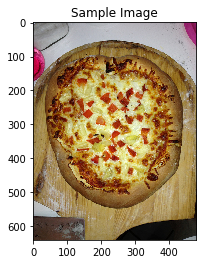

out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[319]], device='cuda:0

In [13]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

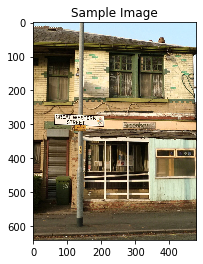

out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[319]], device='cuda:0

In [14]:
get_prediction()

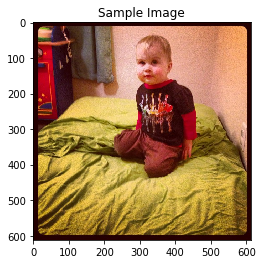

out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[319]], device='cuda:0

In [15]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

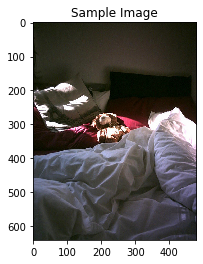

out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[319]], device='cuda:0

In [16]:
get_prediction()

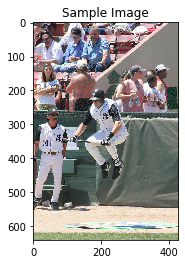

out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[0]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[3]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[169]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[130]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[170]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[77]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[32]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[514]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[39]], device='cuda:0')
out:  torch.Size([1, 1, 256])
x:  torch.Size([1, 1, 8856])
tokens:  tensor([[319]], device='cuda:0

In [17]:
get_prediction()

### Plotting loss and perplexity

In [27]:
import pandas as pd

# find out where the log file is
!ls 

0_Dataset.ipynb				   __pycache__
1_Preliminaries.ipynb			   README.md
2_Training.html				   requirements.txt
2_Training.ipynb			   training_log1571315322.txt
3_Inference.html			   training_log_1571315823.txt
3_Inference.ipynb			   training_log_1571316251.txt
4_Zip Your Project Files and Submit.ipynb  training_log_1571665497.txt
data_loader.py				   training_log_1571669816.txt
decoder-1.pkl				   training_log_1571730453.txt
encoder-1.pkl				   training_log_1572788319.txt
filelist.txt				   training_log-Copy1.txt
images					   training_log_lr2.txt
LICENSE					   training_log.txt
model-Copy1.py				   train.py
model.py				   vocab.pkl
models					   vocabulary.py
project2.zip


In [28]:
log_fn = 'training_log_1572788319.txt'
with open(log_fn, 'r') as f:
    log = f.readlines()

log = [l.replace('\n','').split(',') for l in log]
log = [[l.replace(' [', ': ').split('/',1)[0] for l in lo] for lo in log]
log_dict = [{l.split(':')[0].strip():float(l.split(':')[1]) for l in lo} for lo in log]

df = pd.DataFrame(log_dict)

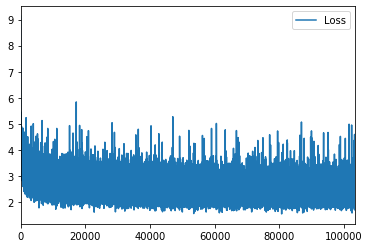

In [27]:
df[['Loss']].plot()

In [18]:
# ignore the outliers at the beginning
df[['Perplexity']][100:].plot()

NameError: name 'df' is not defined

In [30]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  # linear layer to transform encoded image
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)  # linear layer to transform decoder's output
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)  # softmax layer to calculate weights

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # (batch_size, num_pixels, attention_dim)
        att2 = self.decoder_att(decoder_hidden)  # (batch_size, attention_dim)
        att = self.full_att(self.relu(att1 + att2.unsqueeze(1))).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        attention_weighted_encoding = (encoder_out * alpha.unsqueeze(2)).sum(dim=1)  # (batch_size, encoder_dim)

        return attention_weighted_encoding, alpha

class AttentionDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=1, pretrained_embeds=None, debug=False):
        super(DecoderRNN, self).__init__()
        
        self.hidden_size = hidden_size
        
        self.word_embeddings = nn.Embedding(vocab_size, embed_size)
        if pretrained_embeds is not None:
            # torch.from_numpy(pretrained_embeds)
            self.word_embeddings = self.word_embeddings.weight.data.copy_(pretrained_embeds)
            self.word_embeddings.weight.requires_grad = False
        
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.dec = nn.Linear(hidden_size, vocab_size)
        
        self.debug = debug
    
    def forward(self, features, captions):
        if self.debug:
            print('features: ', features.shape)
            print('captions: ', captions.shape)
        
        embeds = self.word_embeddings(captions[:,:-1])
        if self.debug:
            print('embeds: ', embeds.shape)
        
        features = features.unsqueeze(1)
        if self.debug:
            print('unsq feats: ', features.shape)
        
        inputs = (features, embeds)
        inputs = torch.cat(inputs,1)
        if self.debug:
            print('inputs: ', inputs.shape)
        
#         inputs = inputs.view(len(inputs), 1, -1)
#         print('inputs.view', inputs.shape)
        
        h_shape = (1, inputs.shape[0], self.hidden_size)
        if self.debug:
            print('h-shape: ', h_shape)
        
        hidden = (torch.randn(h_shape).cuda(), 
                  torch.randn(h_shape).cuda())  # clean out hidden state
        
        out, hidden = self.lstm(inputs, hidden)
        if self.debug:
            print('out: ', out.shape)
            print('hidden: ', hidden[0].shape)
        
        token_space = self.dec(out)
        if self.debug:
            print('token_space: ', token_space.shape)
        
#         token_scores = F.log_softmax(x, dim=1) # nn.CrossEntory takes care of this
#         if self.debug:
#             print('token_scores: ', token_scores.shape)
        
        return token_space

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        output = []
        # clear hidden state
        h_shape = (1, inputs.shape[0], self.hidden_size)
        hidden = (torch.randn(h_shape).cuda(), torch.randn(h_shape).cuda())
        # loop until <end> token is sampled or maximum length is reached
#         out, hidden = self.lstm()
        for i in range(max_len):
            out, hidden = self.lstm(inputs, hidden)
            if self.debug:
                print('out: ', out.shape)
            
            x = self.dec(out)
            if self.debug:
                print('x: ', x.shape)
            
            values, tokens = torch.max(x, dim=-1)
            if self.debug:
                print('tokens: ',tokens)
            token = tokens.item()
            output.append(token)
            if token==1:
                break
            inputs = self.word_embeddings(tokens)
        return output

NameError: name 'nn' is not defined